In [2]:
import numpy as np
from PIL import Image
import math
from sklearn.cluster import KMeans
from sklearn import metrics
from plotly.graph_objects import Figure
from plotly.express import colors
import colorcet
from IPython.display import Markdown
from random import Random
from collections.abc import Iterable, Callable
from skimage.color import rgb2lab, lab2rgb
import heapq

# ToDo

- HSL space for difference instead of RGB
  - still testing
- ~~median cut algorithm~~
  - seems to average colors too much instead of finding difference
- adapt split metric to use universal model improvement, e.g. increase n
- ~~potentially use fixed color difference, and maybe divicively remove colors from the set that way, or view it like an approximate set cover problem~~
  - this kind of works, but will pick the center of two colors, and the two edges, making three clusters instead of 2
- maybe gaussian mixture model, with circular, but different covariances?
- LAB if HSL still bad
- maybe try xmeans, but with fixed variance, maybe even for bic? Does that that prevent it from trying to make small clusters?
- try using better [distance metric](https://en.wikipedia.org/wiki/Color_difference) for xmeans / arbitrary distance metric

In [3]:
type FloatArray = np.ndarray[tuple[int, ...], np.dtype[np.float64]]
type IntArray = np.ndarray[tuple[int, ...], np.dtype[np.int32]]

In [4]:
def scale_centers(n_centers: int, scale: Iterable[str] = colorcet.glasbey) -> np.ndarray:
    """create rgb 'centers' given an arbitrary color scale, useful to color image according to clusters"""
    return np.array([colors.hex_to_rgb(color) for color in scale[:n_centers]], "u1")

In [10]:
def rgb2hslc(points: np.ndarray, *, axis: int = -1) -> FloatArray:
    mx = points.max(axis) / 255
    mn = points.min(axis) / 255
    r, g, b = np.rollaxis(points, axis) / 255
    c = mx - mn
    lightness = mn + c / 2
    # saturation = c / np.where(c == 0, 1, 1 - np.abs(2 * lightness - 1))
    cs = np.where(c == 0, 1, c)
    options = np.stack([(g - b) / cs, (b - r) / cs + 2, (r - g) / cs + 4]) * np.pi / 3
    hue, = np.take_along_axis(options, points.argmax(axis)[None], 0)
    ex = np.cos(hue) * c / 2
    wy = np.sin(hue) * c / 2
    return np.stack([ex, wy, lightness - 1/2], axis)

def hslc2rgb(points: FloatArray, *, axis: int = -1) -> np.ndarray:
    ex, wy, zee = np.rollaxis(points, -1)
    lightness = zee + 0.5
    hue = np.atan2(wy, ex) % (2 * np.pi)
    c = (ex ** 2 + wy ** 2) ** 0.5 * 2
    hp = hue * 3 / np.pi
    x = c * (1 - np.abs(hp % 2 - 1))
    z = np.zeros_like(x)
    options = np.stack([c, x, z, x, c, z, z, c, x, z, x, c, x, z, c, c, z, x], 0).reshape(6, 3, -1)
    (r, g, b), = np.take_along_axis(options, np.floor(hp).astype("i4")[None, None], 0)
    mn = lightness - c / 2
    normed = np.stack([r + mn, g + mn, b + mn], axis)
    return np.round(255 * normed).astype("u1")

In [24]:
points = np.random.randint(0, 256, (8196, 3), "u1")
x, y, z = rgb2hslc(points).T
Figure().add_scatter3d(x=x, y=y, z=z, mode="markers", marker_color=points).update_layout(width=600, height=600)

In [13]:
_SEED_MAX = 4294967296

def comp_bic(points: np.ndarray, centers: np.ndarray, labels: np.ndarray, *, min_var: float = 0, pop_num: int = 0, pop_var: float = 0) -> float:
    n, _ = points.shape
    k, d = centers.shape
    p = (d + 1) * k
    base_var = np.mean((points - centers[labels]) ** 2)
    tot = n + pop_num
    var = max(base_var * (n / tot) + pop_var * (pop_num / tot), min_var)
    counts = np.bincount(labels)
    # TODO should we use the total data points rather than the split? They should peanalize splits more...
    return counts @ np.log(counts) - 1/2 * tot * d * np.log(var) - p / 2 * np.log(tot)


# TODO FIXME population variance, at least for BIC computation, does that help prevent increasing clusters too much, or maybe it's a minimum variance?
# TODO better account for splitting on overbic, rather than just slit BIC, this would use the total population for complexity versus the subpopulation
# TODO update for arbitrary distance metric, so we can use complicated color distances in lab space
def xmeans(points: FloatArray, kmax: int, *, seed: int | None = None, min_var: float = 0, pop_n: bool = False) -> tuple[np.ndarray, np.ndarray]:
    n_points, _ = points.shape
    rnd = Random(seed)
    labels = np.zeros(n_points, dtype="i4")
    centers = points.mean(0)[None]

    while len(centers) < kmax:

        # Improve Params
        kmeans = KMeans(n_clusters=len(centers), init=centers, random_state=rnd.randint(0, _SEED_MAX)).fit(points)
        labels = kmeans.labels_
        centers = kmeans.cluster_centers_
        pop_var = np.mean((points - centers[labels]) ** 2)

        # Improve Structure
        # Split each cluster into two subclusters and calculate BIC of each splitted cluster
        new_centers = np.concat([centers, np.empty_like(centers)], 0)
        k = len(centers)

        # split in a random order in case we reach kmax
        order = [*enumerate(centers)]
        rnd.shuffle(order)
        for i, center in order:
            if k == kmax:
                break
            mask = labels == i
            mask_points = points[mask]
            n_mask, _ = mask_points.shape
            obic = comp_bic(mask_points, center[None], np.broadcast_to(0, n_mask), min_var=min_var, pop_var=pop_var, pop_num=n_points - n_mask if pop_n else 0)

            split_res = KMeans(n_clusters=2, random_state=rnd.randint(0, _SEED_MAX)).fit(mask_points)
            split_labels = split_res.labels_
            split_centers = split_res.cluster_centers_
            nbic = comp_bic(mask_points, split_centers, split_labels, min_var=min_var, pop_var=pop_var, pop_num=n_points - n_mask if pop_n else 0)

            if obic < nbic:
                new_centers[[i, k]] = split_centers
                k += 1

        split = k > len(centers)
        centers = new_centers[:k]
        if not split:
            break

    # Calculate labels and centroids
    kmeans = KMeans(n_clusters=len(centers), init=centers, random_state=rnd.randint(0, _SEED_MAX)).fit(points)
    return kmeans.labels_, kmeans.cluster_centers_

In [14]:

def median_cut(points: FloatArray, kmax: int = 20) -> tuple[np.ndarray, np.ndarray]:
    tot, dim = points.shape
    diffs = np.diff(np.sort(points, 0), 1, 0)
    # compute the gap between items, so even if all of an axis is the same, we treat it as a small window for bic purposes
    gaps = np.nanmin(np.where(diffs <= 0, np.nan, diffs), 0)

    def _item(inds: np.ndarray, seq: int) -> tuple[float, int, int, float, np.ndarray]:
        sub = points[inds]
        mn = sub.min(0)
        mx = sub.max(0)
        span = mx - mn
        axis = span.argmax()
        return -span[axis].item(), seq, axis, (span + gaps).prod(), inds


    queue = [_item(np.arange(tot), 1)]
    for _ in range(kmax - 1):
        item = heapq.heappop(queue)
        _, seq, axis, ospan, inds = item
        seq *= 2
        num, = inds.shape
        split = num // 2
        ord = points[inds, axis].argpartition(split)
        lower, higher = np.split(inds[ord], [split], 0)
        low_item = _item(lower, seq)
        _, _, _, lspan, _ = low_item
        high_item = _item(higher, seq + 1)
        _, _, _, hspan, _ = high_item

        bic_pre = num * (np.log(num) - np.log(ospan)) - dim * np.log(tot)
        bic_post = lower.size * ( np.log(lower.size) - np.log(lspan)) + higher.size * ( np.log(higher.size) - np.log(hspan)) - (4 * dim + 1) / 2 * np.log(tot)

        if bic_pre > bic_post: # stop splitting
            queue.append(item)
            break
        else:
            heapq.heappush(queue, low_item)
            heapq.heappush(queue, high_item)

    assigns = np.empty(tot, "i4")
    centers: list[np.ndarray] = []
    for i, (_, _, _, _, inds) in enumerate(queue):
        assigns[inds] = i
        sub = points[inds]
        mn = sub.min(0)
        mx = sub.max(0)
        centers.append((mx - mn) / 2 + mn)

    cents = np.stack(centers)
    return assigns, cents

In [15]:
def euclidian(left: FloatArray, right: FloatArray) -> FloatArray:
    return np.sum((left - right) ** 2, -1)

def geometric_cover(points: FloatArray, kmax: int, *, dist: Callable[[FloatArray, FloatArray], FloatArray] = euclidian, thresh: float = 1, seed: int | None = None) -> tuple[np.ndarray, np.ndarray]:
    num, _ = points.shape
    full_dist_mat = dist(points[:, None], points[None]) # very expensive
    dist_mat = full_dist_mat
    inds = np.arange(num)

    assigns = np.empty(num, "i4")
    centers = np.empty(kmax, "i4")

    for ind in range(kmax):
        if not inds.size:
            centers = centers[:ind]
            break

        nearby = dist_mat < thresh
        center_ind = nearby.sum(1).argmax()
        selected = nearby[center_ind]
        centers[ind] = inds[center_ind]
        assigns[inds[selected]] = ind

        dist_mat = dist_mat[~selected][:, ~selected]
        inds = inds[~selected]

    if inds.size:
        # assign to nearest center
        assigns[inds] = full_dist_mat[inds][:, centers].argmin(1)

    return assigns, points[centers]

In [16]:
rng = np.random.default_rng()
k = 8
d = 3
n = 8 * 1024
centers = rng.standard_normal((k, d)) * 8
points = rng.multinomial(1, rng.dirichlet(np.ones(k)), n) @ centers + rng.standard_normal((n, d))

In [17]:
x, y, z = points.T
Figure().add_scatter3d(x=x, y=y, z=z, mode="markers").update_layout(width=600, height=600, paper_bgcolor="rgba(0,0,0,0)")

In [18]:
assigns, centers = xmeans(points, 10, pop_n=False, min_var=2 ** 2)
print(centers.shape)
x, y, z = points.T
Figure().add_scatter3d(
    x=x, y=y, z=z, mode="markers", marker_color=scale_centers(len(centers))[assigns]
).update_layout(width=600, height=600, paper_bgcolor="rgba(0,0,0,0)")

(6, 3)


In [70]:
assigns, centers = median_cut(points, 50)
print(centers.shape)
x, y, z = points.T
Figure().add_scatter3d(
    x=x, y=y, z=z, mode="markers", marker_color=scale_centers(len(centers))[assigns]
).update_layout(width=600, height=600, paper_bgcolor="rgba(0,0,0,0)")

(41, 3)


In [71]:
assigns, centers = geometric_cover(points, 20, thresh=20)
print(centers.shape)
x, y, z = points.T
Figure().add_scatter3d(
    x=x, y=y, z=z, mode="markers", marker_color=scale_centers(len(centers))[assigns]
).update_layout(width=600, height=600, paper_bgcolor="rgba(0,0,0,0)")

(20, 3)


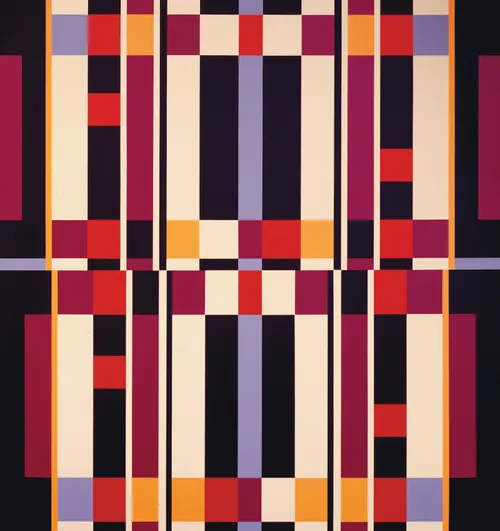

In [147]:
img = Image.open("images/sanin.png")
# img = Image.open("images/kandinski.jpeg")
img

In [148]:
rgb = np.asarray(img)

In [149]:
height, width, _ = rgb.shape

In [150]:
bpm = 60
duration = 30

In [151]:
approxBeats = (bpm * duration) / 60
scale = (approxBeats / (width * height)) ** 0.5
nwidth = round(width * scale)
swidth = (width + nwidth - 1) // nwidth
nheight = round(height * scale)
sheight = (height + nheight - 1) // nheight

In [152]:
target = rgb.copy()
for ys in range(0, height, sheight):
    for xs in range(0, width, swidth):
        patch = target[ys:ys+sheight, xs:xs+swidth]
        break
    break

In [153]:
points = patch.reshape(-1, 3)

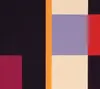

In [154]:
Image.fromarray(patch)

In [155]:
x, y, z = rgb2lab(points).T
Figure().add_scatter3d(
    x=x, y=y, z=z, mode="markers", marker_color=points
).update_layout(width=600, height=600, paper_bgcolor="rgba(0,0,0,0)", title="LAB : True color")

In [156]:
x, y, z = rgb2hslc(points).T
Figure().add_scatter3d(
    x=x, y=y, z=z, mode="markers", marker_color=points
).update_layout(width=600, height=600, paper_bgcolor="rgba(0,0,0,0)", title="HSL : True Color")

In [157]:
x, y, z = points.T
Figure().add_scatter3d(
    x=x, y=y, z=z, mode="markers", marker_color=points
).update_layout(width=600, height=600, paper_bgcolor="rgba(0,0,0,0)", title="RGB : True Color")

In [158]:
# RGB
assigns, centers = xmeans(patch.reshape(-1, 3), kmax=20, min_var=15 ** 2)
print(len(centers))

6


In [159]:
# HSL, seems cleaner
assigns, raw_centers = xmeans(rgb2hslc(patch.reshape(-1, 3)), kmax=20, min_var=0.04 ** 2)
centers = hslc2rgb(raw_centers)
print(len(centers))

6


In [160]:
# LAB
assigns, raw_centers = xmeans(rgb2lab(patch.reshape(-1, 3) / 255), kmax=20, min_var=8 ** 2)
centers = np.round(lab2rgb(raw_centers) * 255).astype("i4")
print(len(centers))

6


## Original Patch

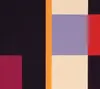

## Clusters

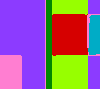

## Cluster Centers

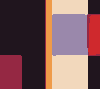

In [161]:
display(Markdown("## Original Patch"))
display(Image.fromarray(patch))
display(Markdown("## Clusters"))
display(Image.fromarray(scale_centers(len(centers))[assigns].reshape(patch.shape)))
display(Markdown("## Cluster Centers"))
Image.fromarray(centers.round().astype("u1")[assigns].reshape(patch.shape))

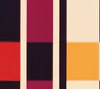

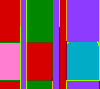

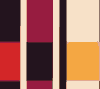

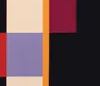

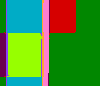

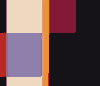

[6, 5, 5, 5, 6, 4, 4, 2, 4, 5, 7, 9, 5, 5, 6, 6, 6, 5, 4, 5, 4, 4, 3, 5, 4, 5, 5, 6, 6, 8]


## Original

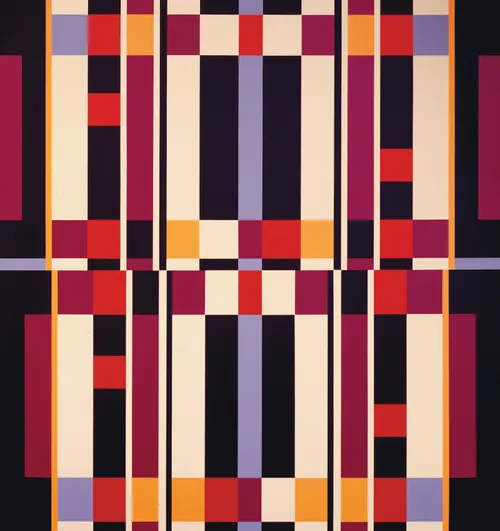

## Clustered

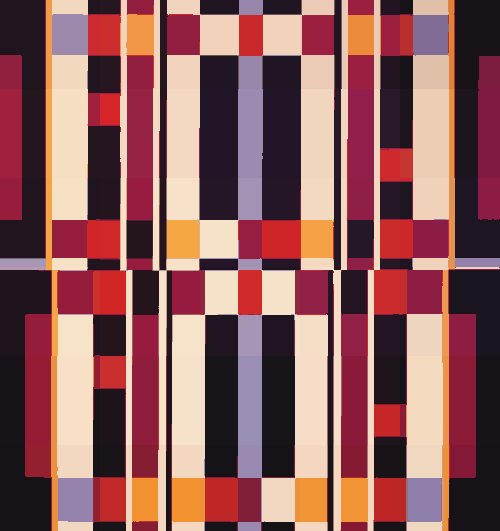

In [ ]:
target = rgb.copy()
num_colors: list[int] = []
for ys in range(0, height, sheight):
    for xs in range(0, width, swidth):
        patch = target[ys:ys+sheight, xs:xs+swidth]
        # empirically, 0.04 ** 2 seems to work pretty well, kmax should probably be like 8
        assigns, raw_centers = xmeans(rgb2hslc(patch.reshape(-1, 3)), kmax=20, min_var=0.04 ** 2)
        centers = hslc2rgb(raw_centers)
        num_colors.append(len(centers))
        recreate = centers[assigns].reshape(patch.shape)
        if len(centers) > 7:
            display(Image.fromarray(patch))
            display(Image.fromarray(scale_centers(len(centers))[assigns].reshape(patch.shape)))
            display(Image.fromarray(recreate))
        np.copyto(patch, recreate)
# FIXME also trim color that are too quiet?
print(num_colors)
display(Markdown("## Original"))
display(Image.fromarray(rgb))
display(Markdown("## Clustered"))
Image.fromarray(target)